In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from src.metrics import (
    adaptive_calibration_error,
    weighted_average,
    plot_calibration_curve)

In [2]:
graphics_format = ".svg"
graphics_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Graphics/SVG/"
tables_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Tables/"
list_of_all_models = [x for x in os.listdir("../results/scores") if not x.startswith(".")]

In [3]:
# Load instance-level results
instance_lvl_results = pd.read_json("../results/instance_level_results.json",
                                    orient="records",
                                    lines=True)

# Experiment 4: Impact of forced epistemicity on accuracy and calibration.

In [4]:
d = {
    "model": [],
    "bear_score": [],
    "first_template": [],
    "weakener": [],
    "strengthener": [],
}
for model in list_of_all_models:
    results = instance_lvl_results[instance_lvl_results["model"] == model]

    grouped = results.groupby("relation").agg({
        "instance": "count",
        "bear_score": "mean",
        "correctly_predicted": "mean",
        "weakener_correctly_predicted": "mean",
        "strengthener_correctly_predicted": "mean"
    }).reset_index()

    d["model"].append(model)
    d["bear_score"].append(weighted_average(grouped, "bear_score") * 100)
    d["first_template"].append(weighted_average(grouped, "correctly_predicted") * 100)
    d["weakener"].append(weighted_average(grouped, "weakener_correctly_predicted") * 100)
    d["strengthener"].append(weighted_average(grouped, "strengthener_correctly_predicted") * 100)

### Table 5.7: Model accuracies on BEAR with forced epistemicity.

In [5]:
(
    pd.DataFrame(d)
    .sort_values(by="model")
    .set_index("model")
    .round(1)
    .to_latex(tables_path + "table_5_7.txt", float_format="%.1f", header=True)
)

### Differences to the non-injected template

In [6]:
agg_results = pd.DataFrame(d).set_index("model")
agg_results["diff_weakener"] = agg_results["weakener"] - agg_results["first_template"]
agg_results["diff_strengthener"] =  agg_results["strengthener"] - agg_results["first_template"]
agg_results.round(2)

,bear_score,first_template,weakener,strengthener,diff_weakener,diff_strengthener
model,,,,,,
opt-350m,19.02,20.41,18.47,18.81,-1.94,-1.60
opt-125m,15.57,17.51,16.19,16.21,-1.32,-1.31
xlm-roberta-large,13.54,14.28,11.95,13.37,-2.33,-0.91
gpt2-medium,18.45,20.73,18.73,18.74,-2.00,-1.99
roberta-large,21.15,22.66,19.56,22.61,-3.10,-0.05
opt-6.7b,42.84,44.00,40.15,40.80,-3.85,-3.21
roberta-base,15.96,17.24,15.87,17.46,-1.37,0.22
gemma-2b,49.97,52.93,49.97,50.54,-2.96,-2.39
xlm-roberta-base,11.16,11.64,10.94,10.24,-0.70,-1.40


### Median-differences

In [7]:
print(f"Weakener: {round(agg_results['diff_weakener'].median(), 2)}",
      f"\nStrengthener: {round(agg_results['diff_strengthener'].median(), 2)}")

Weakener: -2.17 
Strengthener: -1.5


In [8]:
# MLMs
mlms = ["bert-base-cased", "bert-large-cased", "roberta-base",
        "roberta-large", "xlm-roberta-base", "xlm-roberta-large"]
print(f"Weakener: {round(agg_results[agg_results.index.isin(mlms)]['diff_weakener'].median(), 2)}",
      f"\nStrengthener: {round(agg_results[agg_results.index.isin(mlms)]['diff_strengthener'].median(), 2)}")

Weakener: -1.85 
Strengthener: -0.67


In [9]:
# CLMs
print(f"Weakener: {round(agg_results[~agg_results.index.isin(mlms)]['diff_weakener'].median(), 2)}",
      f"\nStrengthener: {round(agg_results[~agg_results.index.isin(mlms)]['diff_strengthener'].median(), 2)}")

Weakener: -2.24 
Strengthener: -2.19


### Table 8: Adaptive Calibration Error on BEAR with forced epistemicity.

In [10]:
def get_ace(df):
    ace_variants = {
        "ace": adaptive_calibration_error(
            predictions=df["correctly_predicted"],
            confidences=df["base_conf"],
            n_bins=20
        ),
        "ace_weakener": adaptive_calibration_error(
            predictions=df["weakener_correctly_predicted"],
            confidences=df["weakener_conf"],
            n_bins=20
        ),
        "ace_strengthener": adaptive_calibration_error(
            predictions=df["strengthener_correctly_predicted"],
            confidences=df["strengthener_conf"],
            n_bins=20
        )
    }
    return pd.Series(ace_variants)

ace_results = instance_lvl_results.groupby("model").apply(get_ace, include_groups=False).round(3)
ace_results.to_latex(tables_path + "table_5_8.txt", float_format="%.1f", header=True)
ace_results["weakener_diff"] = ace_results["ace_weakener"] - ace_results["ace"]
ace_results["strengthener_diff"] = ace_results["ace_strengthener"] - ace_results["ace"]
ace_results

,ace,ace_weakener,ace_strengthener,weakener_diff,strengthener_diff
model,,,,,
bert-base-cased,0.454,0.457,0.461,0.003,0.007
bert-large-cased,0.452,0.480,0.465,0.028,0.013
gemma-2b,0.113,0.099,0.132,-0.014,0.019
gemma-7b,0.077,0.071,0.100,-0.006,0.023
gpt2,0.295,0.315,0.332,0.020,0.037
gpt2-large,0.236,0.239,0.256,0.003,0.020
gpt2-medium,0.249,0.265,0.286,0.016,0.037
gpt2-xl,0.240,0.243,0.270,0.003,0.030
opt-1.3b,0.207,0.208,0.239,0.001,0.032


In [11]:
print(f"Weakener: {round(ace_results['weakener_diff'].median(), 4)}",
      f"\nStrengthener: {round(ace_results['strengthener_diff'].round(3).median(), 4)}")

Weakener: 0.003 
Strengthener: 0.0195


In [12]:
print(f"Weakener: {round(ace_results[ace_results.index.isin(mlms)]['weakener_diff'].median(), 4)}",
      f"\nStrengthener: {round(ace_results[ace_results.index.isin(mlms)]['strengthener_diff'].median(), 4)}")

Weakener: 0.0035 
Strengthener: 0.01


In [13]:
print(f"Weakener: {round(ace_results[~ace_results.index.isin(mlms)]['weakener_diff'].median(), 4)}",
      f"\nStrengthener: {round(ace_results[~ace_results.index.isin(mlms)]['strengthener_diff'].median(), 4)}")

Weakener: 0.003 
Strengthener: 0.0305


### Figure 5.6: Epistemic calibration curves for gemma-2b, gemma-7b and opt-6.7b

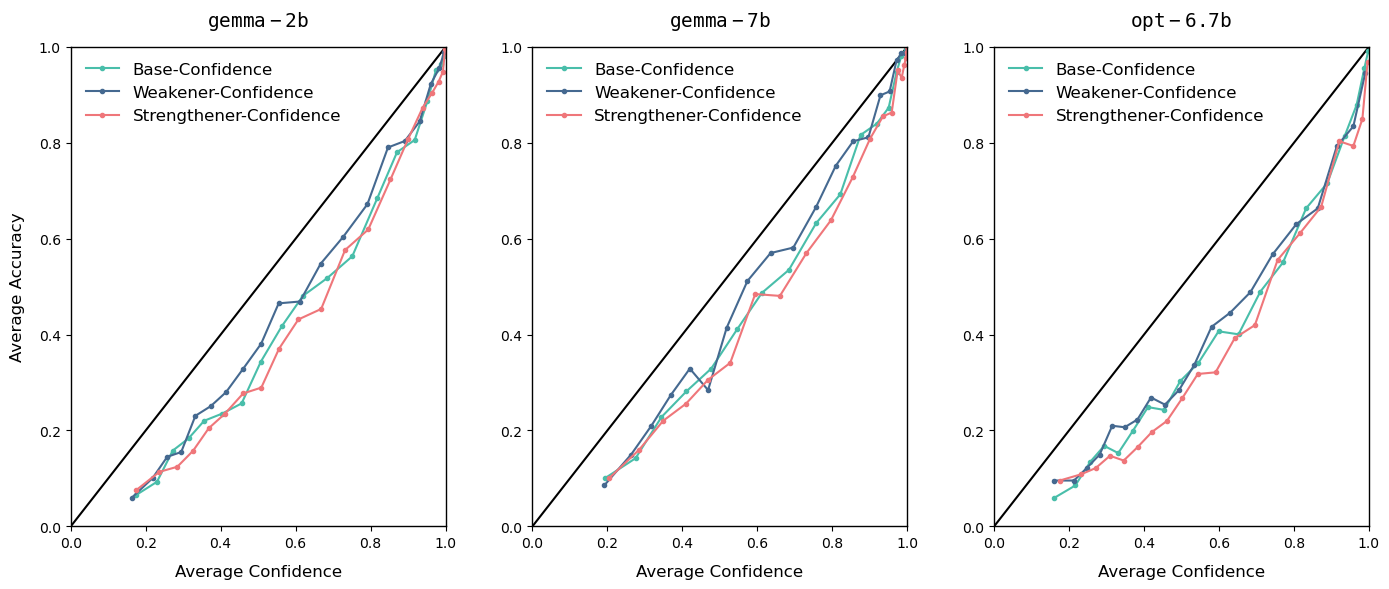

In [14]:
_, axes = plt.subplots(1, 3, figsize=(14, 6), facecolor="white", sharey=True)

gemma_2b = instance_lvl_results[instance_lvl_results["model"] == "gemma-2b"]
plot_calibration_curve(
    title=rf"$\mathtt{{gemma - 2b}}$",
    predictions=[gemma_2b["correctly_predicted"].tolist(),
                 gemma_2b["weakener_correctly_predicted"].tolist(),
                 gemma_2b["strengthener_correctly_predicted"].tolist()],
    confidences=[gemma_2b["base_conf"].tolist(),
                 gemma_2b["weakener_conf"].tolist(),
                 gemma_2b["strengthener_conf"].tolist()],
    labels=["Base-Confidence", "Weakener-Confidence", "Strengthener-Confidence"],
    linestyles=["solid"]*3,
    colors=["#49beaa", "#456990", "#ef767a"],
    markers=["."]*3,
    title_fontsize=14,
    legend_fontsize=12,
    axes_label_fontsize=12,
    axis=axes[0]
)
gemma_7b = instance_lvl_results[instance_lvl_results["model"] == "gemma-7b"]
plot_calibration_curve(
    title=rf"$\mathtt{{gemma-7b}}$",
    predictions=[gemma_7b["correctly_predicted"].tolist(),
                 gemma_7b["weakener_correctly_predicted"].tolist(),
                 gemma_7b["strengthener_correctly_predicted"].tolist()],
    confidences=[gemma_7b["base_conf"].tolist(),
                 gemma_7b["weakener_conf"].tolist(),
                 gemma_7b["strengthener_conf"].tolist()],
    labels=["Base-Confidence", "Weakener-Confidence", "Strengthener-Confidence"],
    linestyles=["solid"]*3,
    colors=["#49beaa", "#456990", "#ef767a"],
    markers=["."]*3,
    title_fontsize=14,
    legend_fontsize=12,
    axes_label_fontsize=12,
    axis=axes[1]
)

opt_6_7b = instance_lvl_results[instance_lvl_results["model"] == "opt-6.7b"]
plot_calibration_curve(
    title=rf"$\mathtt{{opt-6.7b}}$",
    predictions=[opt_6_7b["correctly_predicted"].tolist(),
                 opt_6_7b["weakener_correctly_predicted"].tolist(),
                 opt_6_7b["strengthener_correctly_predicted"].tolist()],
    confidences=[opt_6_7b["base_conf"].tolist(),
                 opt_6_7b["weakener_conf"].tolist(),
                 opt_6_7b["strengthener_conf"].tolist()],
    labels=["Base-Confidence", "Weakener-Confidence", "Strengthener-Confidence"],
    linestyles=["solid"]*3,
    colors=["#49beaa", "#456990", "#ef767a"],
    markers=["."]*3,
    title_fontsize=14,
    legend_fontsize=12,
    axes_label_fontsize=12,
    axis=axes[2]
)
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.savefig(graphics_path + "calibration_curves_epistemic" + graphics_format)
plt.show()